## Wake County - Restaurant Food Inspections Analysis

In [60]:
# import pandas, numpy, matplotlib, seaborn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing the requests library
import requests
# import json
import json

# importing sklearn modules for preprocessing, pipelines, and modeling 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error,mean_squared_error, accuracy_score, recall_score, plot_roc_curve, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix

In [2]:
!pip install tpot

### Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)
 5. [Yelp LIVES data](https://www.yelp.com/healthscores/feeds)

Note: We're sourcing and pre-processing all the data in other notebooks. We have saved the pre-processed data in csv files so we can load them into dataframes in our main file here. If you do want to source them from here, you're free to do so.

## Fetch Restaurant Inspections

In [61]:
inspectionsdf = pd.read_csv('preprocessed_inspections.csv')
print(inspectionsdf.shape)
inspectionsdf.head()

(32742, 6)


,OBJECTID,HSISID,SCORE,DATE,TYPE,INSPECTOR
0,22332274,4092017542,94.5,2017-04-07,Inspection,Anne-Kathrin Bartoli
1,22332275,4092017542,92.0,2017-11-08,Inspection,Laura McNeill
2,22332276,4092017542,95.0,2018-03-23,Inspection,Laura McNeill
3,22332277,4092017542,93.5,2018-09-07,Inspection,Laura McNeill
4,22332278,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske


## Fetch Restaurant Data 

In [62]:
restaurantsdf = pd.read_csv('preprocessed_restaurants.csv')
print(restaurantsdf.shape)
restaurantsdf.head()

(2380, 12)


,OBJECTID,HSISID,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,PERMITID,X,Y,GEOCODESTATUS
0,1924822,4092016155,DAILY PLANET CAFE,11 W JONES ST,RALEIGH,27601,1.919708e+10,2012-04-12,2,-78.639431,35.782205,M
1,1924823,4092016161,HIBACHI 88,3416 POOLE RD,RALEIGH,27610,1.919231e+10,2012-04-18,4,-78.579533,35.767246,M
2,1924824,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,CARY,27511,1.919459e+10,2016-03-11,5,-78.778021,35.787986,M
3,1924825,4092018352,Prime Barbeque,403 KNIGHTDALE STATION RUN,KNIGHTDALE,27545,1.919374e+10,2020-04-22,6,-78.473566,35.797225,M
4,1924828,4092017192,STARBUCKS #19453,185 GRAND HILL PL,HOLLY SPRINGS,27540,1.919557e+10,2016-04-05,16,-78.849481,35.662665,M


## Fetch violations

In [63]:
violationsdf = pd.read_csv('preprocessed_violations.csv')
print(violationsdf.shape)
violationsdf.head()

(226604, 11)


,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,SEVERITY,SHORTDESC,INSPECTEDBY,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE
0,190682112,4092016699,2017-03-24,Approved Source,NaN,NaN,Food obtained from approved source,Angela Myers,0.0,IN,NaN
1,190682241,4092030492,2021-06-14,Approved Source,NaN,NaN,Food obtained from approved source,David Adcock,1.0,OUT,NaN
2,190682242,4092017453,2017-10-18,Approved Source,NaN,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,VR
3,190682243,4092015754,2017-11-15,Approved Source,NaN,NaN,Food obtained from approved source,Maria Powell,0.0,OUT,CDI
4,190682250,4092110015,2018-04-17,Approved Source,NaN,NaN,Food received at proper temperature,Laura McNeill,1.0,OUT,CDI


## Fetch weather data

In [64]:
weatherdatadf = pd.read_csv('preprocessed_weatherdata.csv')
weatherdatadf.head()

,date,TAVG
0,2017-01-01,46.0
1,2017-01-02,50.0
2,2017-01-03,48.0
3,2017-01-04,56.0
4,2017-01-05,40.0


## Fetch Yelp Ratings Data

In [65]:
# read in yelp restaurant data

yelpdatadf = pd.read_csv('preprocessed_yelpdata.csv')
print(yelpdatadf.shape)
display(yelpdatadf.head())

(2144, 7)


,name,review_count,rating,price,phone,display_phone,category_title
0,Peace China,63,3.5,1,19196769968,(919) 676-9968,chinese
1,Asian Cafe,7,3.0,2,19196769968,(919) 676-9968,chinese
2,Northside Bistro & Cocktails,23,4.5,-1,19198905225,(919) 890-5225,american (new)
3,The Daily Planet Cafe,89,4.0,2,19197078060,(919) 707-8060,cafes
4,Hibachi 88,46,3.5,1,19192311688,(919) 231-1688,japanese


## Pull legend from YELP Lives

In [66]:
legend = pd.read_csv('YELP(LIVES)/legend.csv')
display(legend)

,minimum_score,maximum_score,description
0,90,100,A
1,80,89,B
2,70,79,C
3,60,69,D
4,0,59,F


## Fetch crime data as proxy (daily police incidents)

In [71]:
crimedatadf = pd.read_csv('preprocessed_crimedata.csv')
print(crimedatadf.shape)
print(crimedatadf['crime_category'].value_counts())
crimedatadf.head()

(239811, 10)
MISCELLANEOUS                     57874
ASSAULT                           30682
LARCENY                           24361
DRUGS                             18623
FRAUD                             15176
VANDALISM                         15010
LARCENY FROM MV                   14928
ALL OTHER OFFENSES                10782
DRUG VIOLATIONS                    7510
WEAPONS VIOLATION                  6821
HUMANE                             6198
BURGLARY/RESIDENTIAL               6193
TRAFFIC                            4925
MV THEFT                           4729
SEX OFFENSES                       3012
ROBBERY                            2659
DISORDERLY CONDUCT                 2150
BURGLARY/COMMERCIAL                2084
STOLEN PROPERTY                    1705
UNAUTHORIZED MOTOR VEHICLE USE     1166
LIQUOR LAW VIOLATIONS               716
EMBEZZLEMENT                        666
JUVENILE                            392
OBSCENE MATERIAL                    342
EXTORTION                  

,OBJECTID,crime_category,crime_code,crime_description,city,reported_date,reported_year,reported_month,reported_day,reported_dayofwk
0,12001,MISCELLANEOUS,81H,Miscellaneous/Missing Person (18 & over),RALEIGH,2017-01-15T03:28:00Z,2017,1,14,Saturday
1,12002,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-07-29T12:35:00Z,2017,7,29,Saturday
2,12007,MISCELLANEOUS,81K,Miscellaneous/Overdose Death,RALEIGH,2017-04-10T22:28:00Z,2017,4,10,Monday
3,12008,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-11-01T18:59:00Z,2017,11,1,Wednesday
4,12017,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,RALEIGH,2017-12-01T01:03:00Z,2017,11,30,Thursday


## Playing around with Visuals (hearsch's playground -- do not touch)

In [10]:
#inspector_stats = final_df.groupby('INSPECTOR').agg({'SCORE':['mean','max','min']})
#inspector_stats

# create a figure and axis 
#fig, ax = plt.subplots() 
# count the occurrence of each class 
#data = final_df['SCORE'].value_counts().sort_index() 
# get x and y data 
#points = data.index 
#frequency = data.values 
# create bar chart 
#ax.bar(points, frequency)
# set title and labels 
#ax.set_title('Inspectors Average Score') 
#ax.set_xlabel('Points') 
#ax.set_ylabel('Frequency')
#ax.margins(x=0,y=0)

# View histogram of each feature amygdala and acc
#fig,ax = plt.subplots(2,2,figsize=(15,10))
#ax[0,0].hist(final_df['SCORE'],bins=10)
#ax[0,0].set_title('amygdala, bins=5')
#ax[0,1].hist(final_df['SCORE'],bins=10)
#ax[0,1].set_title('acc, bins=5')
#ax[1,0].hist(final_df['SCORE'],bins=20)
#ax[1,0].set_title('amygdala, bins=20')
#ax[1,1].hist(final_df['SCORE'],bins=20)
#ax[1,1].set_title('acc, bins=20')
#plt.show()

# Bar chart of counts for each inspection score given
#plt.figure(figsize=(12,10))
#final_df['SCORE'].value_counts().sort_index().plot(kind='bar')
#plt.tight_layout()
#plt.xlabel('Score')
#plt.ylabel('Frequency')
#plt.title('Average Inspection Scores')
#plt.show()

## Brainstorm Features

1.  Restaurant Data: POSTALCODE, RESTAURANTOPENDATE, X, Y, CITY
2.  Weather Data: Date (index), Avg Daily Hourly Temperature
3.  Restaurant Violations: the entirety / all features now

## Processing of data & feature engineering

## Combining DataFrames 

In [11]:
# Create copy of original DataFrames
rest_inspect = inspectionsdf.copy()
rest_df = restaurantsdf.copy()
rest_violation = violationsdf.copy()
temp_df = weatherdatadf.copy()
yelp_df = yelpdatadf.copy()
score_legend = legend.copy()
crime_df = crimedatadf.copy()

In [12]:
def get_score_grade(legend_df, score):
    legend_dict = score_legend.to_dict('records')
    for d in legend_dict:
        if score >= d['minimum_score'] and score <= d['maximum_score']:
                return d['description']

In [13]:
def aggregate_violations(rest_violation):

    rest_violation['CRITICAL'].fillna("No", inplace=True)
    rest_violation['CRITICAL'] = rest_violation['CRITICAL'].apply(lambda x: (x=='Yes'))
    #print(restv['CRITICAL'].value_counts(dropna=False))
    
    agg_critical = rest_violation.groupby(['HSISID','INSPECTDATE'],as_index=False)['CRITICAL'].agg('sum')
    agg_critical['HAS CRITICAL'] = agg_critical['CRITICAL'] > 0
    
    return agg_critical

aggregate_violations(rest_violation.copy())

,HSISID,INSPECTDATE,CRITICAL,HAS CRITICAL
0,0,2020-12-21,2,True
1,0,2021-03-16,1,True
2,4092010018,2017-05-11,2,True
3,4092010018,2017-08-07,4,True
4,4092010018,2018-01-10,2,True
...,...,...,...,...
36882,4092300292,2020-09-30,1,True
36883,4092300292,2021-06-30,1,True
36884,4092300293,2021-05-10,0,False
36885,4092300293,2021-09-28,1,True


In [14]:
pd.set_option('display.max_columns', None)

def create_feature_table(rest_inspect, rest_df, rest_violation, temp_df, score_legend, crime_df, yelp_df):
    # Merged the inspectionsdf & restaurantsdf based on HSISID (which is primary key for identifying a resto)
    final_df = rest_inspect.merge(rest_df, how='left', on=['HSISID'])
    final_df.drop(['OBJECTID_x', 'OBJECTID_y'], axis=1, inplace=True)
    
    # merge temperature data
    final_df = final_df.merge(temp_df, how='left', left_on='DATE', right_on='date')
    final_df.drop(['date'], axis=1, inplace=True)
    
    # merge with yelp data on the restaurant name
    final_df["NAME"] = final_df["NAME"].str.lower()
    yelp_df["name"] = yelp_df["name"].str.lower()
    final_df = final_df.merge(yelp_df, left_on="NAME", right_on="name", how="left")
    
    final_df.drop_duplicates(['DATE', 'HSISID'], inplace=True)
    final_df.drop(['display_phone', 'name', 'PHONENUMBER'], axis=1, inplace=True)
    final_df.dropna(subset=['review_count'], inplace=True)
    
    # agg and merge crime data
    crime_df['reported_year'] = crime_df['reported_year'].astype(str)
    crime_df['reported_month'] = crime_df['reported_month'].astype(str)
    crime_df['reported_day'] = crime_df['reported_day'].astype(str)
    crime_df['crimedate'] = crime_df[['reported_year', 'reported_month', 'reported_day']].agg('-'.join, axis=1)
    crime_df['crimedate'] = pd.to_datetime(crime_df['crimedate'])
    
    
    crimedfagg = crime_df.groupby(['crimedate']).size()
    crimedfagg = pd.DataFrame(crimedfagg, columns=['crime_count']).reset_index()
    
    
    # merge featuretable with the crime aggregated per day
    featuretable = final_df.copy()
    featuretable['DATE'] = pd.to_datetime(featuretable['DATE'])
    featuretable = featuretable.merge(crimedfagg, how='left', left_on='DATE', right_on='crimedate')
    featuretable=featuretable.drop(['crimedate'], axis=1)
    featuretable = featuretable.drop_duplicates(subset=['SCORE', 'DATE', 'NAME'])
    featuretable['price'] = featuretable['price'].fillna(featuretable['price'].mode()[0])
    
    
    finalfeat= featuretable.copy()
    finalfeat['POSTALCODE'] = finalfeat['POSTALCODE'].str.split('-').str[0]

    finalfeat['RESTAURANTOPENDATE'] = pd.to_datetime(finalfeat['RESTAURANTOPENDATE'])
    finalfeat['DAYS OPEN SINCE INSPECTION'] = (pd.to_datetime(finalfeat['DATE']) - pd.to_datetime(finalfeat['RESTAURANTOPENDATE'])).dt.days
    finalfeat = finalfeat.drop(['phone','ADDRESS1','GEOCODESTATUS','RESTAURANTOPENDATE'], axis=1)
    finalfeat.CITY = finalfeat.CITY.str.lower()
    finalfeat['SCORE GRADE'] = finalfeat['SCORE'].apply(lambda s: get_score_grade(score_legend, s))
    
    
    agg_critical = aggregate_violations(rest_violation)
    #print(agg_critical['HAS CRITICAL'].value_counts())
    finale = finalfeat.copy()
    agg_critical['INSPECTDATE'] = pd.to_datetime(agg_critical['INSPECTDATE'])
    finale = finalfeat.merge(agg_critical, how='inner', left_on=['DATE', 'HSISID'], right_on=['INSPECTDATE', 'HSISID'])
    finale.drop(['DATE', 'SCORE', 'SCORE GRADE'], axis=1, inplace=True)
    #print(finale.isna().sum())
    print(finale['HAS CRITICAL'].value_counts())

    return finale
    
finale = create_feature_table(rest_inspect.copy(), rest_df.copy(), rest_violation.copy(), temp_df.copy(), score_legend.copy(), crime_df.copy(), yelp_df.copy())
print(finale.shape)
finale.head()

True     5301
False     917
Name: HAS CRITICAL, dtype: int64
(6218, 19)


,HSISID,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,category_title,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE,CRITICAL,HAS CRITICAL
0,4092017542,Inspection,Anne-Kathrin Bartoli,american deli,raleigh,27610,33.0,-78.61376,35.754388,53.0,10.0,3.5,1.0,chicken wings,149,37,2017-04-07,4,True
1,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,45.0,10.0,3.5,1.0,chicken wings,110,252,2017-11-08,4,True
2,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,42.0,10.0,3.5,1.0,chicken wings,142,387,2018-03-23,3,True
3,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,33.0,-78.61376,35.754388,81.0,10.0,3.5,1.0,chicken wings,157,555,2018-09-07,2,True
4,4092017542,Inspection,Joanne Rutkofske,american deli,raleigh,27610,33.0,-78.61376,35.754388,60.0,10.0,3.5,1.0,chicken wings,145,764,2019-04-04,2,True


### Build pipeline
Let's create a pipeline from all the preprocessing and modeling steps for our problem.  Below are the steps we will need to incldue for our pipeline for this problem:  
- **Data preprocessing:**  
    - Numerical features:  
        - Fill missing data with median value of feature
        - Standardize each feature. 
    - Categorical features:  
        - Fill missing data with mode value of feature  
        - One-hot encode values for each feature. 
- **Modeling:**  
    - Train a linear regression model on the data
    
We can create two transformer pipelines for the preprocessing of the numerical features and the categorical features, and combine them using `ColumnTransformer` to apply them to the numerical features and categorical features respectively.  We can then place our `ColumnTransformer` in a pipeline together with our model (`LinearRegression`).  

We fit the entire pipeline on our training data (X_train and y_train) using `pipeline.fit(X_train,y_train)`.  Once our pipeline is fitted, we can then apply it to new data using `pipeline.predict(new_data)`.  The preprocessing steps in the pipeline are first applied to the new data and then the processed data is fed into the LinearRegression model to generate predictions.

In [42]:
# created function for splitting data 
def split_data(df):
    # Split data into train and test sets
    X = df.drop(['CRITICAL', 'HAS CRITICAL', 'HSISID'],axis=1)
    y = df['HAS CRITICAL']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0, shuffle=True)
    return X_train,X_test,y_train,y_test

print(finale['HAS CRITICAL'].value_counts(dropna=False))
X_train, X_test, y_train, y_test = split_data(finale)

True     5301
False     917
Name: HAS CRITICAL, dtype: int64


In [43]:
numeric_features = ['review_count', 'crime_count', 'TAVG', 'DAYS OPEN SINCE INSPECTION', 'X', 'Y']
categorical_features = ['TYPE', 'INSPECTOR', 'CITY', 'category_title']
ordinal_features = ['NAME', 'INSPECTDATE', 'POSTALCODE', 'rating', 'price']

def encode_traindf(X, numeric_features, categorical_features, ordinal_features):
    for col in categorical_features:
        X[categorical_features] = X[categorical_features].astype(str)

    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[categorical_features])
    # Get the names of the new columns created
    colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))

    # Transform the data
    onehot_vals = onehot_enc.transform(X[categorical_features]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(categorical_features,axis=1)

    ord_enc =  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[ordinal_features] = ord_enc.fit_transform(X[ordinal_features])

    scaler_num = StandardScaler()
    scaler_ord = StandardScaler()
    X[numeric_features] = scaler_num.fit_transform(X[numeric_features])
    X[ordinal_features] = scaler_ord.fit_transform(X[ordinal_features])
    return X, ord_enc, scaler_num, scaler_ord, onehot_enc

def encode_testdf(X, ord_enc, scaler_num, scaler_ord, onehot_enc, numeric_features, categorical_features, ordinal_features):
    for col in categorical_features:
        X[categorical_features] = X[categorical_features].astype(str)
        
    # Get the names of the new columns created
    colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))

    # Transform the data
    onehot_vals = onehot_enc.transform(X[categorical_features]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(categorical_features,axis=1)
    
    X[ordinal_features] = ord_enc.transform(X[ordinal_features])

    # scale
    X[numeric_features] = scaler_num.transform(X[numeric_features])
    X[ordinal_features] = scaler_ord.transform(X[ordinal_features])
    
    return X
    

print(X_train.shape, X_test.shape)
X_train, ord_enc, scaler_num, scaler_ord, onehot_enc = encode_traindf(X_train.copy(), numeric_features, categorical_features, ordinal_features)
X_test = encode_testdf(X_test.copy(), ord_enc, scaler_num, scaler_ord, onehot_enc, numeric_features, categorical_features, ordinal_features)
display(X_train.head())
display(X_test.head())
print(X_train.shape, X_test.shape)

(4974, 16) (1244, 16)


,NAME,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Anne-Kathrin Bartoli,INSPECTOR_Ashley Whittington,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dimitri Parker,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_title_tapas/small plates,category_title_tea rooms,category_title_tex-mex,catego

,NAME,POSTALCODE,PERMITID,X,Y,TAVG,review_count,rating,price,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Anne-Kathrin Bartoli,INSPECTOR_Ashley Whittington,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dimitri Parker,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_title_tapas/small plates,category_title_tea rooms,category_title_tex-mex,catego

(4974, 180) (1244, 180)


## Univariate Feature selection

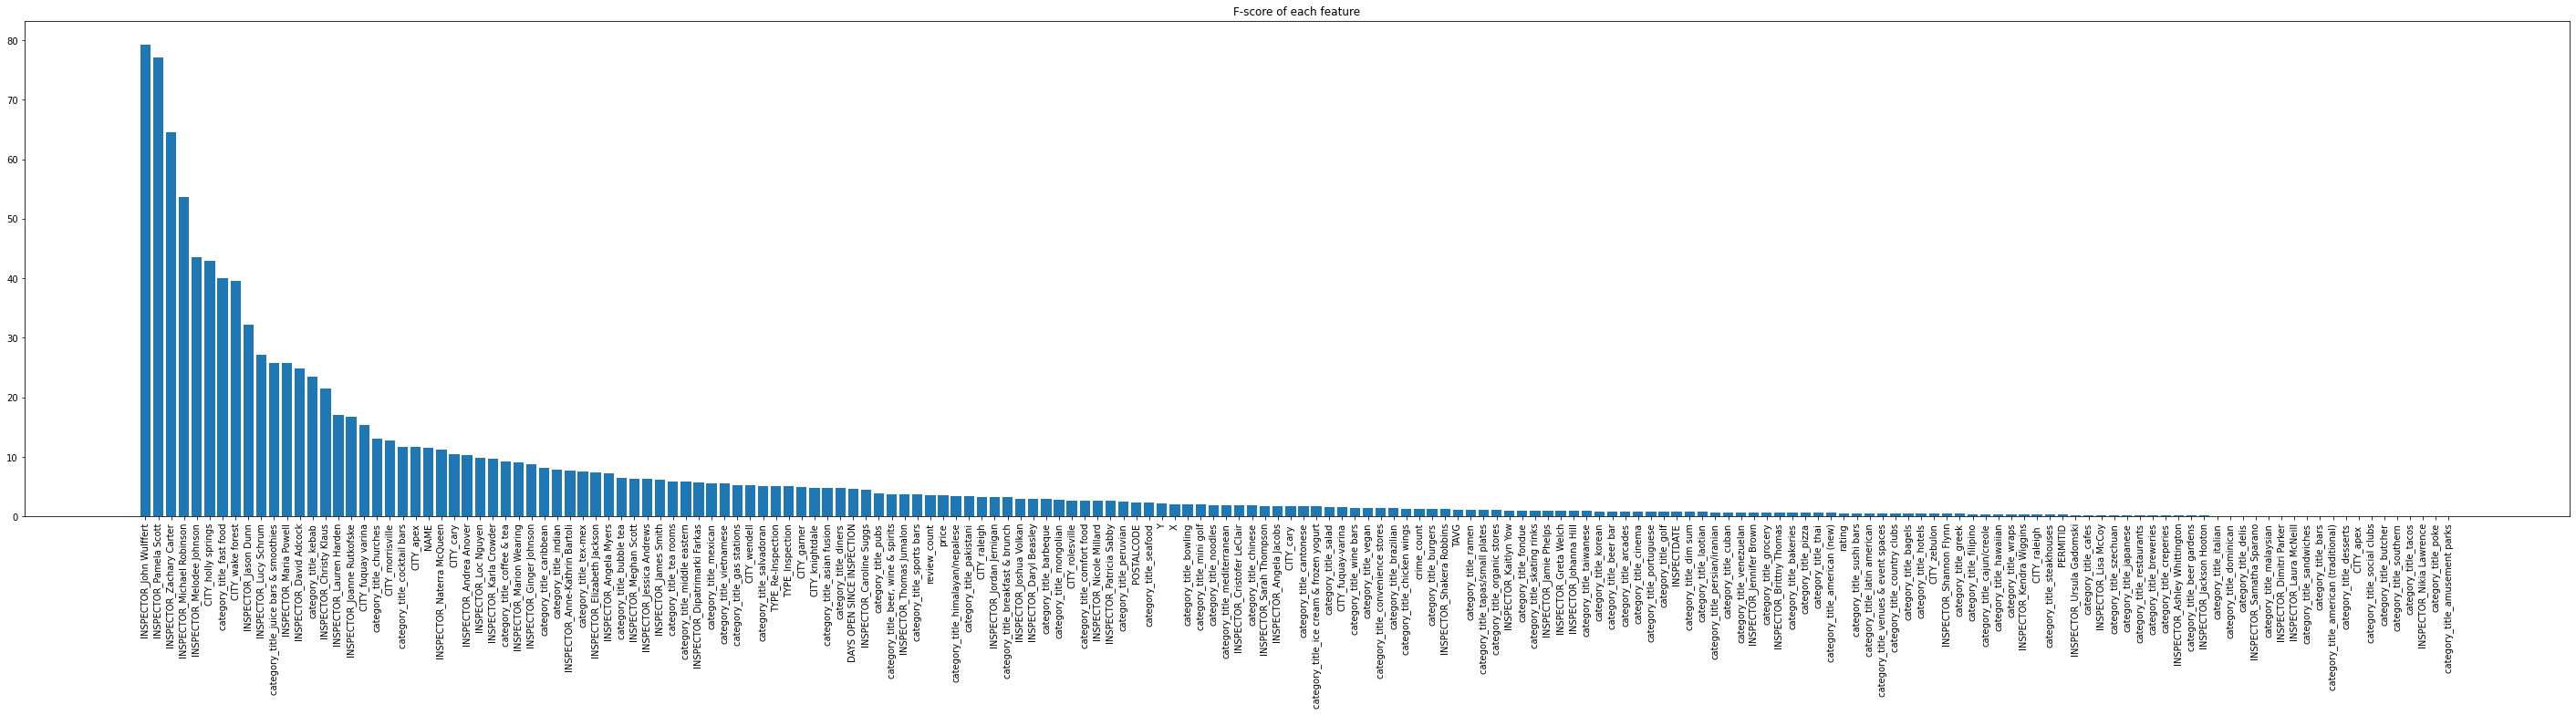

,Feature,F-Score
38,INSPECTOR_John Wulffert,79.309460
57,INSPECTOR_Pamela Scott,77.166420
65,INSPECTOR_Zachary Carter,64.582802
53,INSPECTOR_Michael Robinson,53.722737
52,INSPECTOR_Melodee Johnson,43.606533
73,CITY_holly springs,42.924207
121,category_title_fast food,40.068234
79,CITY_wake forest,39.522934
33,INSPECTOR_Jason Dunn,32.232950
48,INSPECTOR_Lucy Schrum,27.142812


In [57]:
def univariate_feature_selection(X_train, y_train):   
    # Evaluate features using ANOVA (score_func = f_classif)
    ftest = SelectKBest(score_func=f_classif, k='all')
    ftest.fit(X_train,y_train)
    f_scores = pd.DataFrame(ftest.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    f_scores = pd.concat([dfcolumns,f_scores],axis=1)
    f_scores.columns = ['Feature','F-Score']  
    f_scores = f_scores.sort_values(by='F-Score',ascending=False)

    # Plot scores
    plt.figure(figsize=(50,10))
    plt.bar(x=f_scores['Feature'],height=f_scores['F-Score'])
    plt.xticks(rotation=90)
    plt.title('F-score of each feature')
    plt.show()
    display(f_scores.head(20))
univariate_feature_selection(X_train, y_train)

In [45]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=3, max_eval_time_mins=0.04, population_size=40, scoring='f1')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9216119513018299

Generation 2 - Current best internal CV score: 0.9216119513018299

3.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsClassifier(RobustScaler(input_matrix), n_neighbors=24, p=2, weights=distance)
0.9171075837742504


Test set accuracy is 0.849
f1_score is 0.917


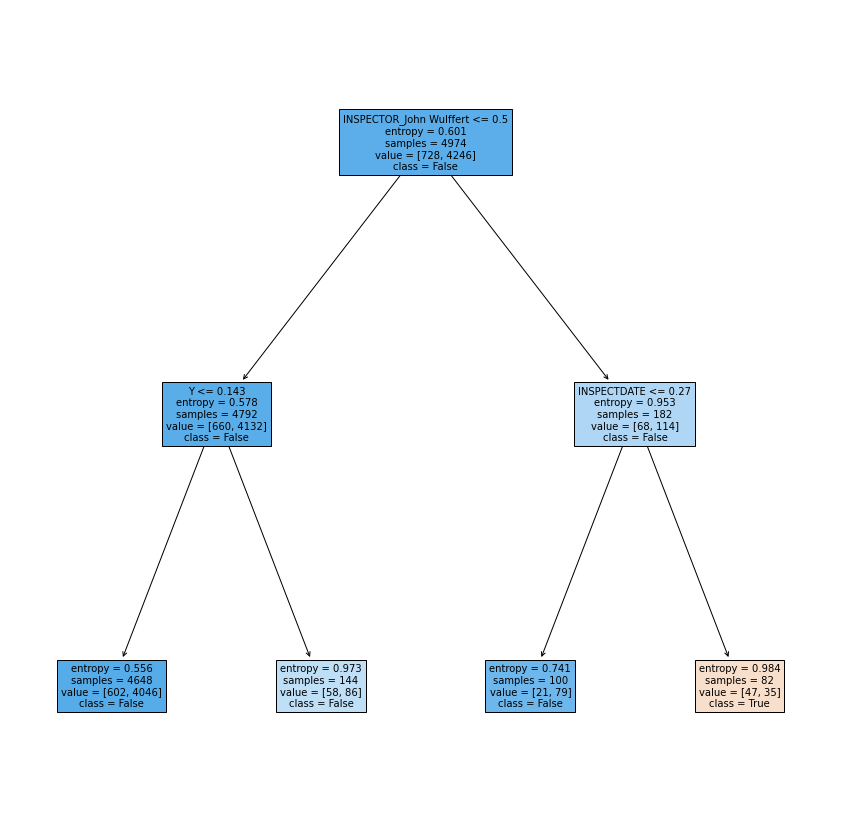

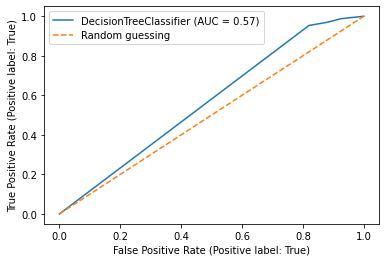

              precision    recall  f1-score   support

       False       0.52      0.07      0.13       189
        True       0.86      0.99      0.92      1055

    accuracy                           0.85      1244
   macro avg       0.69      0.53      0.52      1244
weighted avg       0.80      0.85      0.80      1244



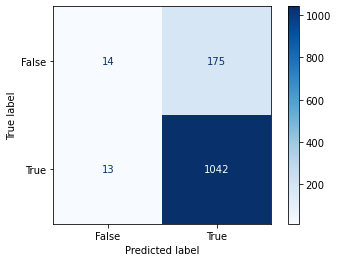

In [58]:
#Best pipeline: DecisionTreeClassifier(SelectPercentile(input_matrix, percentile=98), criterion=gini, max_depth=4, min_samples_leaf=10, min_samples_split=7)
#0.8553639846743295
#Best pipeline: LogisticRegression(SelectPercentile(MinMaxScaler(input_matrix), percentile=31), C=15.0, dual=False, penalty=l2)
#0.8545016077170418
#Best pipeline: KNeighborsClassifier(RobustScaler(input_matrix), n_neighbors=24, p=2, weights=distance)
#f1: 0.9171075837742504

def train(X_train, y_train, X_test, y_test):
    # Instantiate the decision tree model
    tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=7, min_samples_split=11)

    # Fit the tree to the data
    tree_model.fit(X_train, y_train)

    test_preds = tree_model.predict(X_test)
    test_acc = np.sum(test_preds==y_test)/len(y_test)
    print('Test set accuracy is {:.3f}'.format(test_acc))
    print('f1_score is {:.3f}'.format(f1_score(y_test, test_preds)))
    
    # Visualize the decision tree
    plt.figure(figsize=(15,15))
    #tree.plot_tree(tree_model, fontsize=10)
    plot_tree(tree_model,feature_names=X_train.columns,class_names=['True', 'False'],filled=True, fontsize=10)
    
    # plot roc curve
    plot_roc_curve(tree_model, X_test, y_test)
    plt.plot([0,1], [0,1], linestyle='--', label='Random guessing')
    plt.legend()
    plt.show()

    print(classification_report(y_test, test_preds))
    plot_confusion_matrix(tree_model, X_test, y_test, cmap=plt.cm.Blues, normalize=None)

train(X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy())